# Sentiment analysis using neural networks

One of the common uses for binary classification in machine learning is analyzing text for sentiment — specifically, assigning a text string a score from 0 to 1, where 0 represents negative sentiment and 1 represents positive sentiment. A restaurant review such as "Best meal I've ever had and awesome service, too!" might score 0.9 or higher, while a statement such as "Long lines and poor customer service" would score closer to 0. Marketing departments sometimes use sentiment-anlysis models to monitor social-media services for feedback so they can respond quickly if, for example, comments regarding their company suddenly turn negative.

To train a neural network to perform sentiment analysis, you need a dataset containing text strings labeled with 0s (for negative sentiment) and 1s (for positive sentiment). Several such datasets are available in the public domain. We will use one containing 50,000 movie reviews, each labeled with a 0 or 1. Once the network is trained, scoring a text string for sentiment is a simple matter of passing it to the network and asking for the probability that the predicted label is 1. A probability of 80% means the sentiment score is 0.8 and that the text is very positive.

![](Images/sentiment.jpg)

## Load and prepare the data

The first step is to load the dataset and prepare it for use in machine learning. Because machine-learning models can't deal with raw text, we'll use Keras's [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to tokenize the training text. And because Keras doesn't include support for removing stop words as Scikit-learn does, we'll use the [Natural Language Tookit](https://www.nltk.org/) (NLTK) to remove stop words such as "the" and "a." Then we'll split the data for training and testing.

In [1]:
import pandas as pd

df = pd.read_csv('Data/reviews.csv', encoding="ISO-8859-1")
df.head()

,Text,Sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


Find out how many rows the dataset contains and confirm that there are no missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       50000 non-null  object
 1   Sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


Remove duplicate rows and check for balance.

In [3]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  What a wasted cast. This is one of the most di...   
1          24884  24884  This movie documents a transformative experien...   

                
          freq  
Sentiment       
0            1  
1            1

Create a feature column *x* containing the text in the "Text" column with stopwords removed, and a label column *y*.

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
    
x = df.apply(lambda row: remove_stop_words(row['Text']), axis=1)
y = df['Sentiment']

Use Keras's [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to tokenize the cleaned text, and then created padded sequences holding up to 500 tokens each.

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 20000
max_length = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

## Train a neural network

Create a neural network containing an [Embedding](https://keras.io/api/layers/core_layers/embedding/) layer for converting sequences into arrays of word vectors and a [Dense](https://keras.io/api/layers/core_layers/dense/) layer for classifying arrays of word vectors.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding

model = Sequential() 
model.add(Embedding(max_words, 32, input_length=max_length)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           640000    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               819328    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,459,457
Trainable params: 1,459,457
Non-trainable params: 0
_________________________________________________________________


Train the network and capture the training history returned by `fit`.

In [7]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=250)

Epoch 1/5
159/159 [==============================] - 10s 13ms/step - loss: 0.5556 - accuracy: 0.6912 - val_loss: 0.5214 - val_accuracy: 0.7815
Epoch 2/5
159/159 [==============================] - 2s 11ms/step - loss: 0.1487 - accuracy: 0.9455 - val_loss: 0.5248 - val_accuracy: 0.8067
Epoch 3/5
159/159 [==============================] - 2s 11ms/step - loss: 0.0410 - accuracy: 0.9894 - val_loss: 0.8684 - val_accuracy: 0.7509
Epoch 4/5
159/159 [==============================] - 2s 11ms/step - loss: 0.0072 - accuracy: 0.9994 - val_loss: 0.9963 - val_accuracy: 0.7614
Epoch 5/5
159/159 [==============================] - 2s 11ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.1418 - val_accuracy: 0.7517


See how the training and validation accuracy evolved and make sure the network was trained for a sufficient number of epochs.

[]

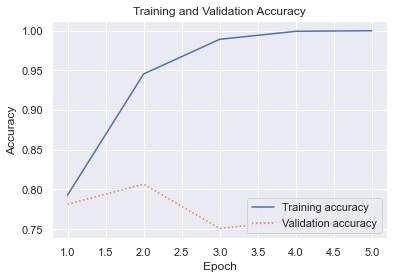

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Use the model to analyze text

Let's score a couple of reviews by tokenizing them and passing them to the model's `predict` method. Start with a positive review.

In [9]:
cleaned_text = remove_stop_words('Excellent food and fantastic service!')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.9064229

And then a negative review.

In [10]:
cleaned_text = remove_stop_words('The long lines and poor customer service really turned me off.')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.030698657

Do the sentiment scores output by the model seem accurate?